In [1]:
import keras
import numpy as np
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input, Lambda, Layer
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import model_from_yaml
from modAL.models import ActiveLearner
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.python.keras.backend import eager_learning_phase_scope
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from keras.layers import MaxPooling2D, concatenate

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
import numpy as np
from matplotlib import pyplot as plt
import math, os

from keras.layers import MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D

In [2]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = X_train.reshape(X_train.shape[0], -1)

X_test = (X_test.astype(np.float32) - 127.5) / 127.5
X_test = X_test.reshape(X_test.shape[0], -1)

In [4]:
BATCH_SIZE = 256
ORIGINAL_DIM = 784
HIDDEN_DIM = 512
EPOCH = 5
epsilon_std = 1.0
#LATENT_DIMS = [2, 4, 8, 16, 32, 64, 128, 256, 512]
LATENT_DIM = 64
usecuda=False
USE_CUDA = False
DEVICE   = ('cuda' if USE_CUDA else 'cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class AdversarialAutoencoder():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.latent_dim = LATENT_DIM

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the encoder / decoder
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()

        img = Input(shape=ORIGINAL_DIM)
        # The generator takes the image, encodes it and reconstructs it
        # from the encoding
        encoded_repr = self.encoder(img)
        reconstructed_img = self.decoder(encoded_repr)

        # For the adversarial_autoencoder model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator determines validity of the encoding
        validity = self.discriminator(encoded_repr)

        # The adversarial_autoencoder model  (stacked generator and discriminator)
        self.adversarial_autoencoder = Model(img, [reconstructed_img, validity])
        self.adversarial_autoencoder.compile(loss=['mse', 'binary_crossentropy'],
            loss_weights=[0.999, 0.001],
            optimizer=optimizer)
        
    def sampling(z_mean, z_log_var):
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon


    def build_encoder(self):
        # Encoder

        img = Input(shape=(ORIGINAL_DIM, ))

        h = Dense(HIDDEN_DIM)(img)
        h = LeakyReLU(alpha=0.2)(h)
        mu = Dense(self.latent_dim)(h)
        log_var = Dense(self.latent_dim)(h)
        
        epsilon = K.random_normal(shape=(K.shape(mu)[0], self.latent_dim), mean=0., stddev=1.0)
        latent_repr =  mu + K.exp(log_var / 2) * epsilon
        
        #latent_repr = self.sampling(mu, log_var)
        return Model(img, latent_repr)

    def build_decoder(self):

        model = Sequential()

        model.add(Dense(HIDDEN_DIM, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(ORIGINAL_DIM, activation='tanh'))

        model.summary()

        z = Input(shape=(self.latent_dim,))
        img = model(z)

        return Model(z, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Dense(512, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation="sigmoid"))
        model.summary()

        encoded_repr = Input(shape=(self.latent_dim, ))
        validity = model(encoded_repr)

        return Model(encoded_repr, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = X_train.reshape(X_train.shape[0], -1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            latent_fake = self.encoder.predict(imgs)
            latent_real = np.random.normal(size=(batch_size, self.latent_dim))

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(latent_real, valid)
            d_loss_fake = self.discriminator.train_on_batch(latent_fake, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator
            g_loss = self.adversarial_autoencoder.train_on_batch(imgs, [imgs, valid])

            # Plot the progress
            print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))

In [6]:
aae = AdversarialAutoencoder()
aae.train(epochs=500, batch_size=32, sample_interval=400)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               33280     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 164,865
Trainable params: 164,865
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
____________________________

c:\users\pinar\onedrive\masaüstü\masterthesis\msthesisenv\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


0 [D loss: 0.803455, acc: 32.81%] [G loss: 1.091441, mse: 1.091776]
1 [D loss: 0.685271, acc: 53.12%] [G loss: 1.018556, mse: 1.018655]
2 [D loss: 0.587592, acc: 76.56%] [G loss: 0.943134, mse: 0.942930]
3 [D loss: 0.538944, acc: 73.44%] [G loss: 0.888388, mse: 0.887879]
4 [D loss: 0.456470, acc: 79.69%] [G loss: 0.820536, mse: 0.819615]
5 [D loss: 0.372677, acc: 82.81%] [G loss: 0.751497, mse: 0.749938]
6 [D loss: 0.289056, acc: 87.50%] [G loss: 0.659000, mse: 0.656251]
7 [D loss: 0.255847, acc: 95.31%] [G loss: 0.582956, mse: 0.579626]
8 [D loss: 0.225700, acc: 96.88%] [G loss: 0.504359, mse: 0.500304]
9 [D loss: 0.184006, acc: 100.00%] [G loss: 0.438018, mse: 0.433334]
10 [D loss: 0.204847, acc: 98.44%] [G loss: 0.350324, mse: 0.345022]
11 [D loss: 0.168873, acc: 100.00%] [G loss: 0.340467, mse: 0.335087]
12 [D loss: 0.151903, acc: 100.00%] [G loss: 0.295508, mse: 0.289756]
13 [D loss: 0.146637, acc: 100.00%] [G loss: 0.298954, mse: 0.293469]
14 [D loss: 0.110638, acc: 100.00%] [G l

116 [D loss: 0.005169, acc: 100.00%] [G loss: 0.126976, mse: 0.118676]
117 [D loss: 0.010271, acc: 100.00%] [G loss: 0.133834, mse: 0.127046]
118 [D loss: 0.013431, acc: 100.00%] [G loss: 0.143013, mse: 0.135825]
119 [D loss: 0.005804, acc: 100.00%] [G loss: 0.137727, mse: 0.129109]
120 [D loss: 0.004827, acc: 100.00%] [G loss: 0.123216, mse: 0.114409]
121 [D loss: 0.010109, acc: 100.00%] [G loss: 0.141134, mse: 0.132688]
122 [D loss: 0.007530, acc: 100.00%] [G loss: 0.137466, mse: 0.130524]
123 [D loss: 0.006837, acc: 100.00%] [G loss: 0.114924, mse: 0.106729]
124 [D loss: 0.005354, acc: 100.00%] [G loss: 0.138826, mse: 0.130721]
125 [D loss: 0.009443, acc: 100.00%] [G loss: 0.117857, mse: 0.110349]
126 [D loss: 0.010591, acc: 100.00%] [G loss: 0.136197, mse: 0.128951]
127 [D loss: 0.005668, acc: 100.00%] [G loss: 0.116630, mse: 0.109174]
128 [D loss: 0.010291, acc: 100.00%] [G loss: 0.120735, mse: 0.112914]
129 [D loss: 0.010517, acc: 100.00%] [G loss: 0.124389, mse: 0.117103]
130 [D

234 [D loss: 0.082246, acc: 96.88%] [G loss: 0.095410, mse: 0.087647]
235 [D loss: 0.326569, acc: 85.94%] [G loss: 0.099422, mse: 0.093387]
236 [D loss: 0.100143, acc: 96.88%] [G loss: 0.104265, mse: 0.087755]
237 [D loss: 0.070561, acc: 96.88%] [G loss: 0.086075, mse: 0.075800]
238 [D loss: 0.366658, acc: 85.94%] [G loss: 0.100434, mse: 0.093448]
239 [D loss: 0.162156, acc: 93.75%] [G loss: 0.114943, mse: 0.093933]
240 [D loss: 0.206896, acc: 90.62%] [G loss: 0.102693, mse: 0.084784]
241 [D loss: 0.267851, acc: 90.62%] [G loss: 0.115856, mse: 0.108507]
242 [D loss: 0.052647, acc: 96.88%] [G loss: 0.101813, mse: 0.086202]
243 [D loss: 0.099544, acc: 95.31%] [G loss: 0.094060, mse: 0.079612]
244 [D loss: 0.332482, acc: 90.62%] [G loss: 0.102364, mse: 0.095643]
245 [D loss: 0.172652, acc: 89.06%] [G loss: 0.104184, mse: 0.091091]
246 [D loss: 0.057897, acc: 98.44%] [G loss: 0.087485, mse: 0.076786]
247 [D loss: 0.089903, acc: 96.88%] [G loss: 0.087180, mse: 0.080024]
248 [D loss: 0.03573

353 [D loss: 0.042806, acc: 98.44%] [G loss: 0.070152, mse: 0.064409]
354 [D loss: 0.064603, acc: 96.88%] [G loss: 0.070340, mse: 0.064499]
355 [D loss: 0.057675, acc: 98.44%] [G loss: 0.078481, mse: 0.072285]
356 [D loss: 0.090289, acc: 96.88%] [G loss: 0.059926, mse: 0.054362]
357 [D loss: 0.090923, acc: 96.88%] [G loss: 0.071337, mse: 0.066832]
358 [D loss: 0.013437, acc: 100.00%] [G loss: 0.067555, mse: 0.059854]
359 [D loss: 0.061161, acc: 98.44%] [G loss: 0.066463, mse: 0.060797]
360 [D loss: 0.027081, acc: 100.00%] [G loss: 0.067955, mse: 0.061569]
361 [D loss: 0.051283, acc: 100.00%] [G loss: 0.079028, mse: 0.072483]
362 [D loss: 0.048531, acc: 100.00%] [G loss: 0.065073, mse: 0.058694]
363 [D loss: 0.035898, acc: 100.00%] [G loss: 0.070288, mse: 0.063456]
364 [D loss: 0.033122, acc: 100.00%] [G loss: 0.065054, mse: 0.059345]
365 [D loss: 0.028651, acc: 100.00%] [G loss: 0.071261, mse: 0.064231]
366 [D loss: 0.077377, acc: 98.44%] [G loss: 0.071515, mse: 0.066430]
367 [D loss: 

474 [D loss: 0.020823, acc: 100.00%] [G loss: 0.063416, mse: 0.056603]
475 [D loss: 0.029521, acc: 98.44%] [G loss: 0.057828, mse: 0.050924]
476 [D loss: 0.070111, acc: 98.44%] [G loss: 0.062376, mse: 0.055803]
477 [D loss: 0.060900, acc: 96.88%] [G loss: 0.068946, mse: 0.061635]
478 [D loss: 0.017664, acc: 100.00%] [G loss: 0.061321, mse: 0.054603]
479 [D loss: 0.034323, acc: 100.00%] [G loss: 0.064972, mse: 0.058931]
480 [D loss: 0.023771, acc: 100.00%] [G loss: 0.063945, mse: 0.055348]
481 [D loss: 0.041462, acc: 100.00%] [G loss: 0.067082, mse: 0.060682]
482 [D loss: 0.055324, acc: 98.44%] [G loss: 0.067167, mse: 0.060123]
483 [D loss: 0.031535, acc: 100.00%] [G loss: 0.062158, mse: 0.055388]
484 [D loss: 0.040660, acc: 100.00%] [G loss: 0.061986, mse: 0.056772]
485 [D loss: 0.021813, acc: 100.00%] [G loss: 0.062857, mse: 0.054927]
486 [D loss: 0.050509, acc: 100.00%] [G loss: 0.071669, mse: 0.065913]
487 [D loss: 0.017297, acc: 100.00%] [G loss: 0.063446, mse: 0.054801]
488 [D los

In [7]:
X_train_enhanced = aae.encoder.predict(X_train, batch_size=32)

X_test_enhanced = aae.encoder.predict(X_test, batch_size=32)

In [8]:
np.save('x_train_enhanced_aae.npy', X_train_enhanced)
np.save('x_test_enhanced_aae.npy', X_test_enhanced)

In [9]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, learning_rate=70, n_iter=2000, n_iter_without_progress=400, verbose=1)
EX2D = tsne.fit_transform(X_train_enhanced)

c:\users\pinar\onedrive\masaüstü\masterthesis\msthesisenv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.006s...
[t-SNE] Computed neighbors for 60000 samples in 107.821s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for s

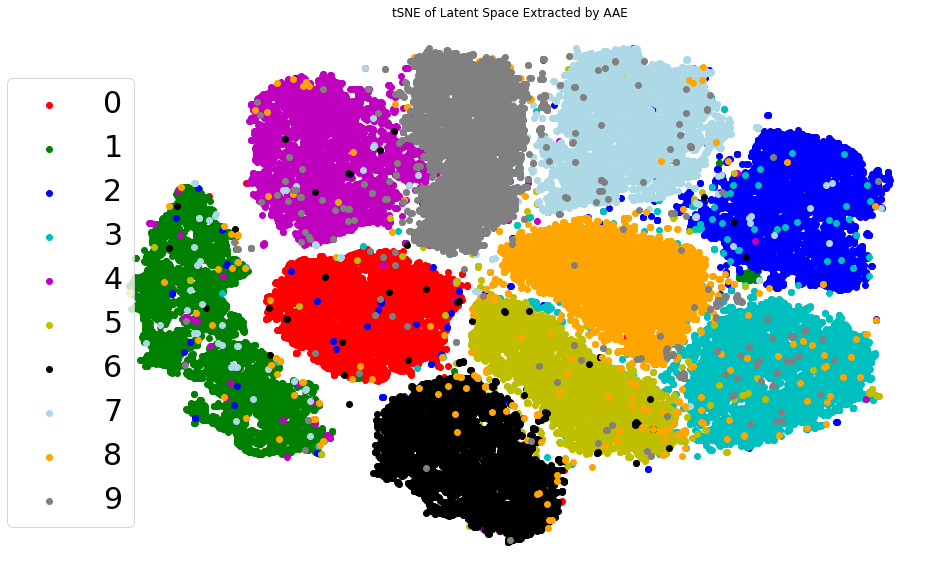

In [10]:
plt.figure(figsize=(15,10))
plt.title("tSNE of Latent Space Extracted by AAE")
plt.rcParams.update({'font.size': 30})
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'lightblue', 'orange', 'gray']

for i, c in zip(list(range(0, 10)), colors):
    idx = y_train==i
    plt.scatter(EX2D[y_train==i, 0], EX2D[y_train==i,1], c=c, label=str(i))
    
plt.legend(bbox_to_anchor=(-0.1, 0.9), loc=2, borderaxespad=0)
plt.axis('off')
plt.savefig(r'.\plots\tSNE_aae.pdf')